In [ ]:
!pip install -q dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.0/251.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203

In [ ]:
import mlflow
import dagshub
dagshub.init(repo_owner='s.carlosj.28', repo_name='moe_image_class', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fd045a82-c074-4aa7-9075-c3246c789ada&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c7689f55e854938d3a9e9e92e3cd6bbfdc10f6c9f1ad3088920e18ccd5f0554d




Accessing as s.carlosj.28

Initialized MLflow to track repo "s.carlosj.28/moe_image_class"

Repository s.carlosj.28/moe_image_class initialized!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import os
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Define transforms
transform = transforms.Compose([
    # Resize the image to 32x32. The MNIST dataset contains vectorized images of 28X28. Therefore we define a new function to reshape each batch of MNIST images to 28X28 and then resize to 32X32. The reason of resizing to 32X32 is to make it a power of two and therefore we can easily use the stride of 2 for downsampling and upsampling.
    # USER: What's the meaning of stride of 2 for downsampling and upsampling?
    transforms.Resize((32, 32)),
    # Convert the image to a pytorch tensor
    transforms.ToTensor(),
    # Normalize the pixel values to be between -1 and 1.
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Image shape: torch.Size([1, 32, 32])
Label: 3


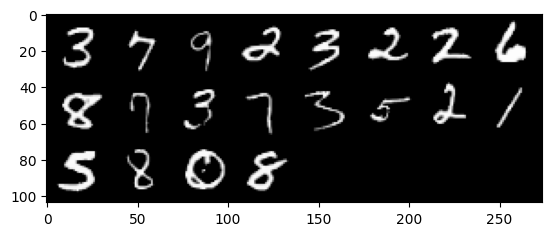

In [14]:
# Data exploration
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"Image shape: {images[0].shape}")
print(f"Label: {labels[0]}")

# Show first images
img = torchvision.utils.make_grid(images[:20])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
# Define the Expert class
class Expert(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # GELU activation function is used in the original paper for the Expert model
        # The GELU is similar to the ReLU function, but includes a smooth curve for the zero values
        self.activation = nn.GELU()

    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))

# Define the MoE layer with top-k routing
class MoELayer(nn.Module):
    def __init__(self, num_experts, d_model, d_ff, k=2):
        super().__init__()
        self.num_experts = num_experts
        self.k = k
        self.gate = nn.Linear(d_model, num_experts)
        self.experts = nn.ModuleList([Expert(d_model, d_ff) for _ in range(num_experts)])

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Compute gate outputs
        gate_outputs = self.gate(x)

        # Select top-k experts
        top_k_gates, top_k_indices = torch.topk(gate_outputs, self.k, dim=-1)
        top_k_gates = torch.softmax(top_k_gates, dim=-1)

        # Compute expert outputs for top-k experts
        expert_outputs = torch.zeros_like(x).unsqueeze(-2).repeat(1, 1, self.k, 1)
        for i in range(self.k):
            idx = top_k_indices[:, :, i]
            expert_outputs[:, :, i, :] = torch.stack([self.experts[idx[b, s]](x[b, s]) for b in range(batch_size) for s in range(seq_len)]).view(batch_size, seq_len, -1)

        # Combine expert outputs using gate outputs
        output = torch.sum(top_k_gates.unsqueeze(-1) * expert_outputs, dim=2)

        return output

# Define the TransformerMoE model
class TransformerMoE(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, num_experts, d_ff, num_classes, patch_size, k=2, expert_placement='all'):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, d_model, kernel_size=patch_size, stride=patch_size)
        self.layers = nn.ModuleList()
        self.moe_layers = nn.ModuleList()

        for i in range(num_layers):
            self.layers.append(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff, batch_first=True))

            if expert_placement == 'all' or (expert_placement == 'odd' and i % 2 == 0) or (expert_placement == 'even' and i % 2 == 1) or (isinstance(expert_placement, list) and i in expert_placement):
                self.moe_layers.append(MoELayer(num_experts, d_model, d_ff, k))
            else:
                # If no MoE layer is added, add a regular feedforward layer
                # self.moe_layers.append(nn.Linear(d_model, d_model))
                # Or add a dummy layer to keep the number of layers consistent
                self.moe_layers.append(nn.Identity()) # No MoE layer

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        for layer, moe_layer in zip(self.layers, self.moe_layers):
            x = layer(x)
            x = moe_layer(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [ ]:
# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy

# Experiment runner
def run_experiment(num_experts, k, expert_placement, patch_size, num_epochs, learning_rate, num_layers):
    mlflow.set_experiment("MNIST_MoE_LongRun")
    # run_name = f"nexperts_{num_experts}_k_{k}_placement_{expert_placement}_patch_size_{patch_size}_epochs_{num_epochs}_lr_{learning_rate}_layers_{num_layers}"
    run_name = f"layers_{num_layers}_placement_{expert_placement}_patch_size_{patch_size}_nexperts_{num_experts}_k_{k}_lr_{learning_rate}_epochs_{num_epochs}"

    # Start an MLflow run
    with mlflow.start_run(run_name = run_name):
        # Log parameters
        mlflow.log_param("model", "TransformerMoE")
        mlflow.log_param("num_experts", num_experts)
        mlflow.log_param("k", k)
        mlflow.log_param("expert_placement", expert_placement)
        mlflow.log_param("patch_size", patch_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_layers", num_layers)

        # Initialize model
        model = TransformerMoE(num_layers=num_layers, num_heads=4, d_model=128, num_experts=num_experts,
                               d_ff=256, num_classes=10, patch_size=patch_size, k=k,
                               expert_placement=expert_placement).to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(num_epochs):
            train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)

            test_accuracy_tr = evaluate(model, testloader, device)
            mlflow.log_metric("test_accuracy", test_accuracy_tr, step=epoch)


        # Evaluate the model
        test_accuracy = evaluate(model, testloader, device)
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        mlflow.log_metric("test_accuracy", test_accuracy)

        # Save the final model
        mlflow.pytorch.log_model(model, "model")

        return test_accuracy

In [ ]:
# Define the configurations
configuration_values = {
    "num_experts": [4], # [2, 4, 8, 16, 32],
    "k": [2], # [2, 4, 8],
    "expert_placement": [[2]], #['all', 'odd', 'even', [0], [1]],
    "patch_size": [16], # [4, 8, 16, 32], # MNIST images have size 28x28 (784 pixels)
    "num_epochs": [50], # [5, 10, 15, 20, 25, 30, 35],
    "learning_rate": [0.0005], # [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
    "num_layers": [3] # [2, 3, 4, 5]
}

configurations = []

# Generate all possible combinations of the configurations:
from itertools import product
for values in product(*configuration_values.values()):
    config = {key: value for key, value in zip(configuration_values.keys(), values)}
    configurations.append(config)

print("total_confs", len(configurations))

# Split the configurations into n_splits to execute in different machines:
n_splits = 1
configurations_splits = [configurations[i::n_splits] for i in range(n_splits)]

# Select a split
split_index = 0
configurations = configurations_splits[split_index]
print("current_split", len(configurations))
print(configurations)

total_confs 1
current_split 1
[{'num_experts': 4, 'k': 2, 'expert_placement': [2], 'patch_size': 16, 'num_epochs': 50, 'learning_rate': 0.0005, 'num_layers': 3}]


In [ ]:
# Run experiments
results = []

for config in configurations:
    print(f"Running experiment with {config['num_experts']} experts, k={config['k']}, placement={config['expert_placement']}, patch_size={config['patch_size']}, epochs={config['num_epochs']}, lr={config['learning_rate']}, layers={config['num_layers']}")
    accuracy = run_experiment(**config)
    results.append((config, accuracy))

# Print results
print("\nExperiment Results:")
for config, accuracy in results:
    print(f"Num Experts: {config['num_experts']}, k: {config['k']}, Placement: {config['expert_placement']}, Patch Size: {config['patch_size']}, Epochs: {config['num_epochs']}, LR: {config['learning_rate']}, Layers: {config['num_layers']}, Test Accuracy: {accuracy:.2f}%")

Running experiment with 4 experts, k=2, placement=[2], patch_size=16, epochs=50, lr=0.0005, layers=3
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16330694.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 500935.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3875108.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 8370179.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/50, Loss: 0.3090, Accuracy: 90.15%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/50, Loss: 0.1305, Accuracy: 95.97%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/50, Loss: 0.1006, Accuracy: 96.76%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/50, Loss: 0.0863, Accuracy: 97.29%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/50, Loss: 0.0750, Accuracy: 97.59%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/50, Loss: 0.0703, Accuracy: 97.73%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/50, Loss: 0.0613, Accuracy: 98.07%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/50, Loss: 0.0618, Accuracy: 97.97%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/50, Loss: 0.0529, Accuracy: 98.33%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.0513, Accuracy: 98.39%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/50, Loss: 0.0507, Accuracy: 98.37%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/50, Loss: 0.0470, Accuracy: 98.48%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/50, Loss: 0.0447, Accuracy: 98.53%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/50, Loss: 0.0417, Accuracy: 98.65%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/50, Loss: 0.0420, Accuracy: 98.67%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/50, Loss: 0.0410, Accuracy: 98.66%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/50, Loss: 0.0392, Accuracy: 98.72%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/50, Loss: 0.0371, Accuracy: 98.78%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/50, Loss: 0.0398, Accuracy: 98.70%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/50, Loss: 0.0355, Accuracy: 98.83%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/50, Loss: 0.0341, Accuracy: 98.86%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
# Inference function
def predict_image(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)

    return predicted.item()

# Example usage of inference function:
# new_image_path = "path/to/your/new/image.png"
# best_model = mlflow.pytorch.load_model("runs:/<run_id>/model")
# prediction = predict_image(best_model, new_image_path, device)
# print(f"Predicted digit: {prediction}")
